# LIVE PREDICTION (CLASSIFICATION)

Importing Libraries and Models

In [1]:
import cv2
import numpy as np
import pandas as pd
import dlib
from skimage.feature import greycomatrix, greycoprops
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import StandardScaler
import joblib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
model = joblib.load("/content/drive/MyDrive/Spechio_Project/Spechio_model_Classification.joblib")

In [4]:
scaler = joblib.load('/content/drive/MyDrive/scaler.save')

In [5]:
predictor_path = '/content/drive/MyDrive/Spechio_Project/shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)

Functions to calculate Features

In [6]:
def detect_landmarks(image):

  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor('/content/drive/MyDrive/Spechio_Project/shape_predictor_68_face_landmarks.dat')

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  faces = detector(gray)

  for face in faces:
    landmarks = predictor(gray,face)

    points = np.zeros((68,2),dtype=int)
    for i in range(0,68):
      points[i] = (landmarks.part(i).x, landmarks.part(i).y)
      x,y = (landmarks.part(i).x, landmarks.part(i).y)
      cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

    cv2_imshow(image)
    return points

In [7]:
def calculate_golden_ratios(landmarks):

    under_eyes = np.linalg.norm(landmarks[41]-landmarks[46])
    interocular = np.linalg.norm(landmarks[39]-landmarks[42])
    nose_width = np.linalg.norm(landmarks[31]-landmarks[35])
    mouth_width = np.linalg.norm(landmarks[48]-landmarks[54])
    upper_lip_jaw = np.linalg.norm(landmarks[51]-landmarks[8])
    lip_height = np.linalg.norm(landmarks[51]-landmarks[57])
    nose_mouth_height = np.linalg.norm(landmarks[33]-landmarks[51])
    eyebrows_nose = np.linalg.norm((np.linalg.norm(landmarks[21]-landmarks[22]))-landmarks[33])/2
    nose_jaw = np.linalg.norm(landmarks[33]-landmarks[9])
    upper_lip_height = np.linalg.norm(landmarks[51]-landmarks[56])/2



    # Calculate the golden ratios
    ratio1 = under_eyes / interocular
    ratio2 = under_eyes / nose_width
    ratio3 = mouth_width / interocular
    ratio4 = upper_lip_jaw/interocular
    ratio5 = upper_lip_jaw / nose_width
    ratio6 = interocular / lip_height
    ratio7 = nose_width / interocular
    ratio8 = nose_width / upper_lip_height
    ratio9 = interocular/nose_mouth_height
    ratio10 = eyebrows_nose / nose_jaw
    ratio11 = interocular / nose_width

    return ratio1, ratio2, ratio3, ratio4, ratio5, ratio6, ratio7, ratio8, ratio9, ratio10, ratio11

In [8]:
def calculate_symmetric_ratios(landmarks):
    upper_eyebrow_numerator = np.linalg.norm(landmarks[21]-((np.linalg.norm(landmarks[22]-landmarks[21]))/2))
    upper_eyebrow_denominator = np.linalg.norm(landmarks[22]-((np.linalg.norm(landmarks[22]-landmarks[21]))/2))

    # Calculate the symmetric ratios
    lower_eyebrow_length = (np.linalg.norm(landmarks[17]-landmarks[21]))/(np.linalg.norm(landmarks[22]-landmarks[26]))
    lower_lip_length = (np.linalg.norm(landmarks[48]-landmarks[57]))/(np.linalg.norm(landmarks[54]-landmarks[57]))
    upper_eyebrow = upper_eyebrow_numerator/upper_eyebrow_denominator
    upper_lip = (np.linalg.norm(landmarks[48]-landmarks[51]))/(np.linalg.norm(landmarks[51]-landmarks[55]))
    nose = (np.linalg.norm(landmarks[31]-landmarks[33]))/(np.linalg.norm(landmarks[33]-landmarks[35]))

    return lower_eyebrow_length, lower_lip_length, upper_eyebrow, upper_lip, nose

In [9]:
def compute_glcm_features(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    glcm = greycomatrix(gray, [1], [0])

    # Calculate the GLCM properties
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]

    return homogeneity, contrast, energy, correlation


In [10]:
def compute_hu_moments(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to create a binary image
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)


    #contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the largest contour (assumed to be the face)
    #largest_contour = max(contours, key=cv2.contourArea)

    # Calculate Hu's moments
    moments = cv2.moments(binary)
    hu_moments = cv2.HuMoments(moments)
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))

    return hu_moments.flatten()

In [11]:
actual_rating = { 1.0: 0 , 1.5: 1 , 2.0: 2 , 2.5: 3 , 3.0: 4 , 3.5: 5 , 4.0: 6 , 4.5: 7 , 5.0: 8}
key_list = list(actual_rating.keys())

Live Webcam Image Capture

In [12]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
#Colab Helper Function to access Webcam
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


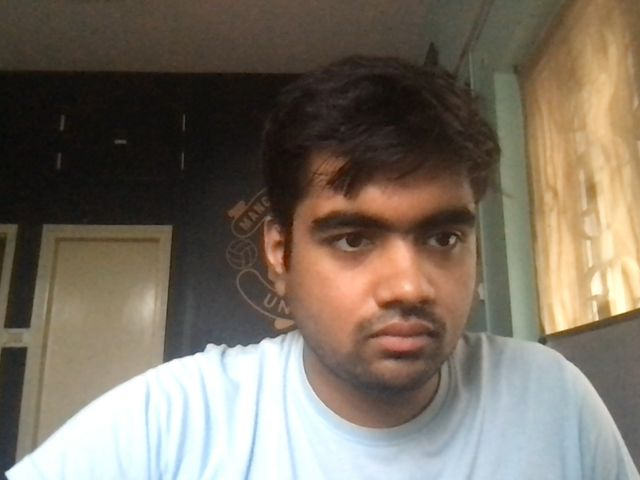

In [13]:
#Access Webcam
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [16]:
image_path = 'photo.jpg'
frame = cv2.imread(image_path)

Prediction

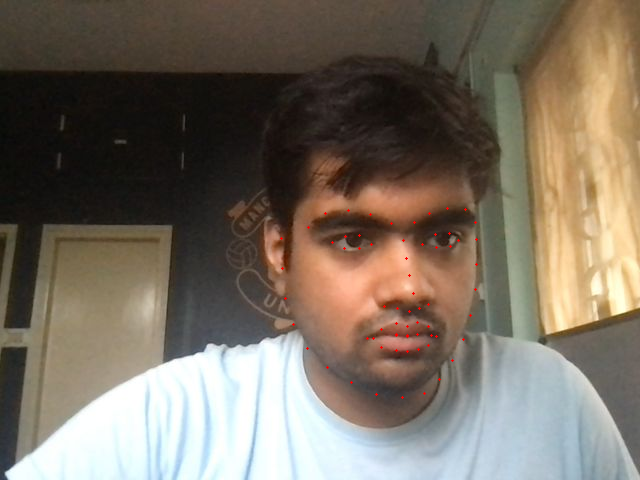



-------------------------------------------------
-------------------------------------------------
The Predicted Rating -  4.0




/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

In [17]:
image_array = np.array(frame)
feature_data = []
# Detect landmarks
landmarks = detect_landmarks(image_array)



#Golden Ratios
ratio1, ratio2, ratio3, ratio4, ratio5, ratio6, ratio7, ratio8, ratio9, ratio10, ratio11 = calculate_golden_ratios(landmarks)

#Symmetric Ratios
lower_eyebrow_length, lower_lip_length, upper_eyebrow, upper_lip, nose = calculate_symmetric_ratios(landmarks)

# Compute GLCM features
glcm_features = compute_glcm_features(image_array)

#Hu Moments
hu_moments = compute_hu_moments(image_array)


feature_data.append({'UE/IO': ratio1, 'UE/NW': ratio2, 'MW/IO': ratio3, 'ULJ/IO': ratio4, 'ULJ/NW': ratio5, 'IO/LH': ratio6,
                     'NW/IO': ratio7, 'NW/ULH': ratio8, 'IO/NMH': ratio9, 'EBN/NJ': ratio10, 'IO/NW': ratio11, 'LEL': lower_eyebrow_length,
                     'LLL': lower_lip_length, 'UEB': upper_eyebrow, 'UL': upper_lip, 'Nose': nose, 'Homogeneity': glcm_features[0],
                         'Contrast': glcm_features[1], 'Energy': glcm_features[2],
                         'Correlation': glcm_features[3], 'HuM1': hu_moments[0],
                         'HuM2': hu_moments[1], 'HuM3': hu_moments[2],
                         'HuM4': hu_moments[3], 'HuM5': hu_moments[4], 'HuM6': hu_moments[5], 'HuM7': hu_moments[6]  })


cv2.imwrite("captured_face.jpg", frame)

# Convert the list of features to a dataframe
df = pd.DataFrame.from_dict(feature_data)
# Scale the Data
df_scaled = scaler.transform(df)
cols = df.columns
df_scaled = pd.DataFrame(df_scaled, columns = cols)
print('\n')
#Feature Encoding
print('-------------------------------------------------')
#predictions
print('-------------------------------------------------')
print("The Predicted Rating - ", key_list[int(model.predict(df_scaled))])
print("\n")